In [1]:
def give_index(c):
  if c == '<S>':
    return 26
  elif c == '<E>':
    return 27
  else:
    return ord(c) - 97

In [2]:
def give_char(num):
    if num == 26:
        c = '<S>'
    elif num == 27:
        c = '<E>'
    else:    
        c = chr(num + 97)
    
    return c

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [13]:
import torch
N = torch.zeros((28,28), dtype=torch.int32)

for word in words:
  chs = ['<S>'] + list(word) + ['<E>'] 
  for ch1,ch2 in zip(chs, chs[1:]):
    N[give_index(ch1),give_index(ch2)] += 1

P = (N+1).float() # in data, we have some zeros, which give infinite negative log likelihood
P /= P.sum(1, keepdims=True)

In [15]:
nll = 0 # negative log likelihood
n = 0
for word in words[:1]:
  chs = ['<S>'] + list(word) + ['<E>']
  for ch1,ch2 in zip(chs, chs[1:]):
        nll += -torch.log(P[give_index(ch1),give_index(ch2)])
        n = n + 1
 
print('all words err = ',nll/n)

all words err =  tensor(2.5144)


In [16]:
x_input = []
y_output = []
for word in words:
    chs = ['<S>'] + list(word) + ['<E>']
    for ch1,ch2 in zip(chs, chs[1:]):
        x_input.append(give_index(ch1))
        y_output.append(give_index(ch2))

import torch.nn.functional as F

xenc = F.one_hot(torch.tensor(x_input), num_classes=28).float()

In [19]:
W = torch.randn((28,28), requires_grad=True)

loss @ end of training =  2.46334171295166


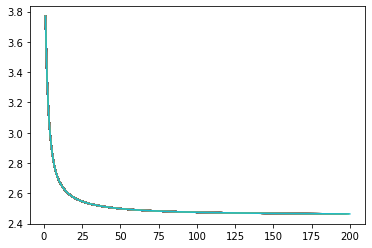

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

loss_over_time = []
# forward pass and backward pass
for p in range(200):
    wx = xenc @ W
    exp_wx = wx.exp()
    prob = exp_wx/exp_wx.sum(1, keepdims=True)
    loss = -prob[torch.arange(len(x_input)),y_output].log().mean()
    loss_over_time.append(loss.item())
    plt.plot(range(1,len(loss_over_time)+1), loss_over_time)
    W.grad = None
    loss.backward()
    W.data += -50*W.grad

print('loss @ end of training = ', loss_over_time[-1])

In [27]:
diff = W.data - P.data
sum(diff**2)

tensor([187.7437,  36.8556,  27.1956,  26.7994, 137.4277,  51.7325,  21.8804,
         52.4587, 120.6510,  37.8814,  26.2533,  45.9948,  24.2358,  50.9218,
         73.5480,  37.7031,  63.5460,  54.8602,  26.8348,  27.3837,  39.7624,
         17.3718,  40.7152,  53.3119,  50.2915,  22.5445,  86.7593, 128.9269])

In [35]:
# sample and check
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 26
  while True:
    
    # ----------
    # BEFORE:
    p = P[ix]
    # ----------
    # NOW:
#     xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
#     logits = xenc @ W # predict log-counts
#     counts = logits.exp() # counts, equivalent to N
#     p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(give_char(ix))
    if ix == 27:
      break
  print(''.join(out))

mroda<E>
tasssi<E>
mus<E>
ke<E>
an<E>


In [37]:
# sample and check
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 26
  while True:
    
    # ----------
    # BEFORE:
#     p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=28).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(give_char(ix))
    if ix == 27:
      break
  print(''.join(out))

mroda<E>
tasssi<E>
mus<E>
ke<E>
an<E>


In [38]:
xenc = F.one_hot(torch.tensor([26]), num_classes=28).float()
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
p = counts / counts.sum(1, keepdims=True) # probabilities for next character



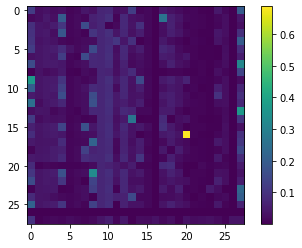

In [50]:
diff = abs(p - P)
mat = diff.detach().numpy()
fig, ax = plt.subplots()
im = ax.imshow(mat, cmap='viridis')

# Add a colorbar to the plot
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()
